<a href="https://colab.research.google.com/github/sarahlai30/Machine-Learning-INDE-577/blob/main/Supervised%20Learning/Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Neural Network from Scratch**

A neural network is a machine learning model inspired by the structure of the human brain, designed to identify patterns and relationships in data. It is particularly powerful for image recognition tasks like those in the Fashion MNIST dataset. A neural network consists of interconnected layers of nodes (neurons) that process input data and produce predictions.

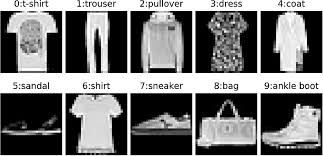

To test our learning model, we will be using the Fashion MNIST dataset consisting of a training set of 60,000 examples and a test set of 10,000 examples.



The Fashion MNIST dataset consists of grayscale images, each sized 28x28 pixels. These images are represented as matrices of pixel intensities, where each value is an integer between 0 and 255. To improve the efficiency and stability of neural network training, these pixel values are normalized to a range between 0 and 1.


In [78]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load Fashion MNIST dataset
(train_X, train_y), (test_X, test_y) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize data to [0, 1]
train_X = train_X / 255.0
test_X = test_X / 255.0

# Function for flattening and one-hot encoding
def preprocess_data(X, y, num_classes=10):

    # Flatten the images
    flat_X = X.reshape(-1, 784, 1)

    # One-hot encode the labels
    onehot_y = np.zeros((len(y), num_classes, 1))
    for idx, label in enumerate(y):
        onehot_y[idx, label, 0] = 1.0

    return flat_X, onehot_y

# Preprocess both train and test sets
flat_train_X, onehot_train_y = preprocess_data(train_X, train_y)
flat_test_X, onehot_test_y = preprocess_data(test_X, test_y)

Each image, initially in 2D format, is converted into a 1D array and then reshaped into a column vector, which is a format commonly required by neural network implementations.

To compare the network’s output with the true labels during training, we use a technique called one-hot encoding.

In one-hot encoding, each label is transformed into a 10x1 vector (for the 10 classes in Fashion MNIST). The vector is filled with zeros, except for a 1.0 at the index corresponding to the label. For example:

Label 2 becomes: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0].

Label 7 becomes: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0].

This process ensures that the network’s sigmoid outputs (which represent probabilities for each class) can be directly compared to the one-hot encoded labels using a binary cross-entropy loss function during training.

In [79]:
def initialize_weights(layers = [784, 60, 60, 10]):
    # The following Python lists will contain numpy matrices
    # connected the layers in the neural network
    W = [[0.0]]
    B = [[0.0]]
    for i in range(1, len(layers)):
        # The scalling factor is something I found in a research paper :)
        w_temp = np.random.randn(layers[i], layers[i-1])*np.sqrt(2/layers[i-1])
        b_temp = np.random.randn(layers[i], 1)*np.sqrt(2/layers[i-1])

        W.append(w_temp)
        B.append(b_temp)
    return W, B

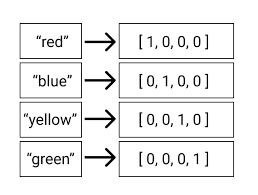

Our objective is to create a custom Python class that implements the desired neural network structure. To build a good understanding of the underlying processes, we will first sequentially develop individual functions for the following:


1.   Initializing the weights and biases for each layer of the network
2.   Implementing the feedforward phase, where inputs are propagated through the network to generate outputs
3. Calculating the cost function, the difference between the predicted and actual outputs
4. Computing the gradient to determine how to adjust weights and biases to minimize the cost
5. Iterating stochastic gradient descent

Defining our sigmoid activation function, its derivative, and the mean squared error for a single instance of training data:

In [80]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def d_sigmoid(z):
    return sigmoid(z)*(1.0 - sigmoid(z))

def mse(a, y):
    return .5*sum((a[i] - y[i])**2 for i in range(10))[0]

Then writing a function to initialize the weight matrices and bias column vectors for a dense neural network:

In [81]:
def forward_pass(W, B, xi, predict_vector = False):
    Z = [[0.0]]
    A = [xi]
    L = len(W) - 1
    for i in range(1, L + 1):
        z = W[i] @ A[i-1] + B[i]
        Z.append(z)

        a = sigmoid(z)
        A.append(a)

    if predict_vector == False:
        return Z, A
    else:
        return A[-1]

def predict(W, B, xi):
    _, A = forward_pass(W, B, xi)
    return np.argmax(A[-1])

def MSE(W, B, X, y):
    cost = 0.0
    m = 0
    for xi, yi in zip(X, y):
        a = forward_pass(W, B, xi, predict_vector = True)
        cost += mse(a, yi)
        m+=1
    return cost/m

Each layer 𝑙 in our neural network operates in two phases: the preactivation phase and the postactivation phase.

*   Preactivation: Compute a weighted linear combination of the postactivation values from the previous layer and include the bias term for the layer.
*   Postactivation Phase: Preactivation values are passed element-wise through an activation function to produce the postactivation values for the current layer.

At the input layer (𝑙 =0), the postactivation values are simply the input data 𝑋 into the network.

To verify that our activation functions and matrix dimensions are working correctly, we can run the following code:

We write a custom function for making a prediction on a random data point, as well as write a mean squared error function that computes the error over an entire set of features and labels.

In [90]:
def random_experiment(W, B, data_features, data_labels):
    """
    Runs a prediction on a random data point from the dataset.
    """
    i = np.random.randint(len(data_features))
    print(f"Actual label: {np.argmax(data_labels[i])}")
    print(f"Predicted label: {predict(W, B, data_features[i])}")

def calculate_mse(W, B, X, y):
    """
    Computes the mean squared error (MSE) over the dataset.
    """
    total_cost = 0.0
    for xi, yi in zip(X, y):
        a = forward_pass(W, B, xi, predict_vector=True)
        total_cost += mse(a, yi)
    return total_cost / len(X)

# Backpropagation with Stochastic Gradient Descent

We are now ready to write a custom Python class, DenseNetwork, which will initialize the weights and biases for our neural network. This class will implement stochastic gradient descent (SGD) for optimizing the network's parameters during training.








In [91]:
class DenseNetwork(object):
    def __init__(self, layers=[784, 60, 60, 10]):
        self.layers = layers
        self.W, self.B = initialize_weights(layers=self.layers)
        self.errors_ = []

    def train(self, X_train, y_train, alpha=0.046, epochs=4):
        """
        Trains the neural network using stochastic gradient descent.
        """
        # Initial Cost Calculation
        self.errors_ = [calculate_mse(self.W, self.B, X_train, y_train)]
        print(f"Starting Cost = {self.errors_[0]}")

        sample_size = len(X_train)
        L = len(self.layers) - 1  # Number of layers excluding input

        for k in range(epochs):
            for xi, yi in zip(X_train, y_train):
                Z, A = forward_pass(self.W, self.B, xi)

                # Initialize deltas dictionary
                deltas = {}

                # Compute output layer error
                output_error = (A[L] - yi) * d_sigmoid(Z[L])
                deltas[L] = output_error

                # Backpropagate errors through hidden layers
                for i in range(L - 1, 0, -1):
                    deltas[i] = (self.W[i + 1].T @ deltas[i + 1]) * d_sigmoid(Z[i])

                # Update weights and biases
                for i in range(1, L + 1):
                    self.W[i] -= alpha * deltas[i] @ A[i - 1].T
                    self.B[i] -= alpha * deltas[i]

            # Calculate and log epoch cost
            epoch_cost = calculate_mse(self.W, self.B, X_train, y_train)
            self.errors_.append(epoch_cost)
            print(f"{k + 1}-Epoch Cost = {epoch_cost}")

    def predict(self, xi):
        """
        Predict the label for a single input xi.
        """
        _, A = forward_pass(self.W, self.B, xi)
        return np.argmax(A[-1])


Starting Cost = 1.1438911245660237
1-Epoch Cost = 0.4369801583826704
2-Epoch Cost = 0.40498357027008214
3-Epoch Cost = 0.36486736683856413
4-Epoch Cost = 0.3285697153049574
5-Epoch Cost = 0.3012512633978005
6-Epoch Cost = 0.2758637897627964
7-Epoch Cost = 0.2526321981712939
8-Epoch Cost = 0.23332866308401767
9-Epoch Cost = 0.21756210225377418
10-Epoch Cost = 0.20432684778044666
11-Epoch Cost = 0.1931084246142539
12-Epoch Cost = 0.18369848367063552
13-Epoch Cost = 0.17581629813341174
14-Epoch Cost = 0.16911663665928325
15-Epoch Cost = 0.1632958860018839
16-Epoch Cost = 0.15812765751690785
17-Epoch Cost = 0.15346388762082555
18-Epoch Cost = 0.14922352530228655
19-Epoch Cost = 0.14534689700539544
20-Epoch Cost = 0.1417777523877874
21-Epoch Cost = 0.13846912974378375
22-Epoch Cost = 0.1353831908575415
23-Epoch Cost = 0.13249023029503504
24-Epoch Cost = 0.12976874896344534
25-Epoch Cost = 0.12720474570442084
26-Epoch Cost = 0.12478841106130108
27-Epoch Cost = 0.12251088030161376
28-Epoch Co

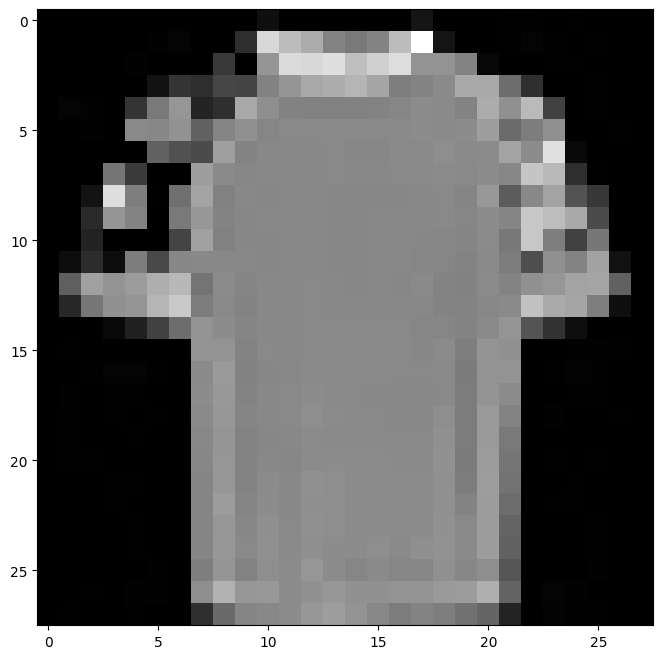

In [109]:
# Initialize the DenseNetwork
model = DenseNetwork(layers=[784, 60, 60, 10])
# Train the model
model.train(flat_train_X[:5000], onehot_train_y[:5000], alpha=0.01, epochs=200)
# Evaluate on test data
correct_predictions = 0
for x, y in zip(flat_test_X[:1000], test_y[:1000]):
    prediction = model.predict(x)
    if prediction == y:
        correct_predictions += 1

# Print accuracy
accuracy = correct_predictions / 1000
print(f"Test Accuracy: {accuracy:.2%}")

plt.figure(figsize=(8, 8))
plt.imshow(x_test[i], cmap="gray")
plt.show()

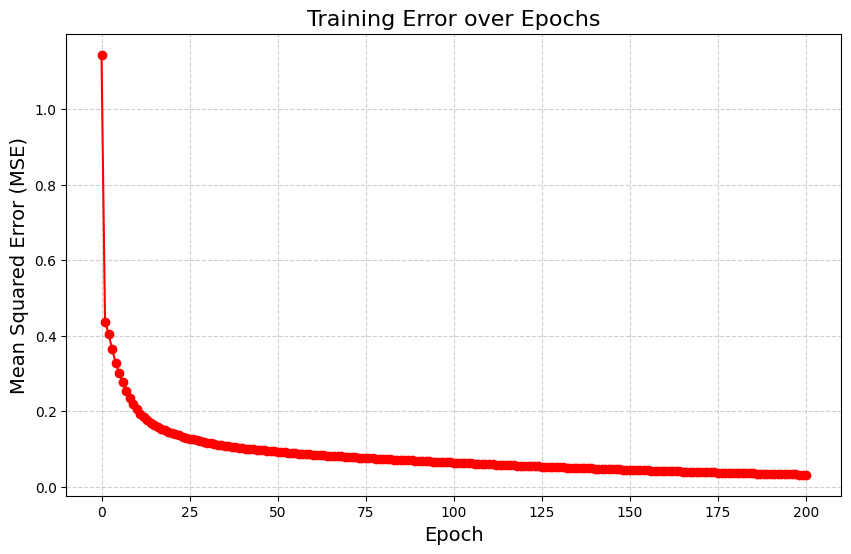

In [110]:
# Plot the training error
plt.figure(figsize=(10, 6))
plt.plot(range(len(model.errors_)), model.errors_, marker='o', color='red')
plt.title("Training Error over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Mean Squared Error (MSE)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

The sharp drop in error during the initial epochs indicates that the network quickly learns meaningful patterns from the data. Following this, the gradual decrease in error suggests a stable convergence toward the optimal solution. By the 200th epoch, the MSE stabilizes at a low value, reflecting the model's improved accuracy.

A test accuracy of 85.50% on the Fashion MNIST dataset is a strong result for a neural network trained with the sigmoid activation function. This accuracy highlights the model's ability to generalize well to unseen test data.